# Problem 1

2/2 [==============================] - 0s 6ms/step
Epoch 1/2, Discriminator Loss: 1.4222701787948608, Generator Loss: 0.13040199875831604
2/2 [==============================] - 0s 7ms/step
Epoch 2/2, Discriminator Loss: 1.4805962443351746, Generator Loss: 0.11506528407335281
1/1 [==============================] - 0s 68ms/step


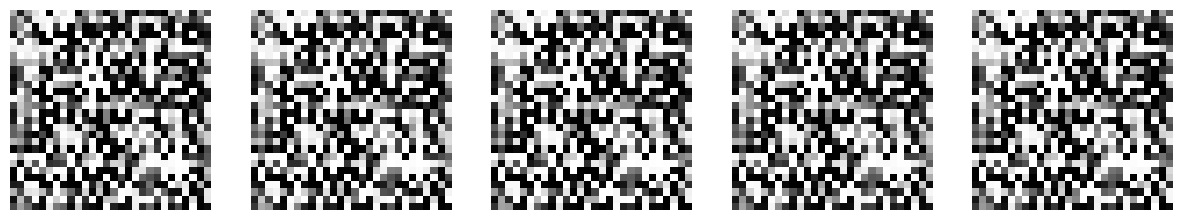

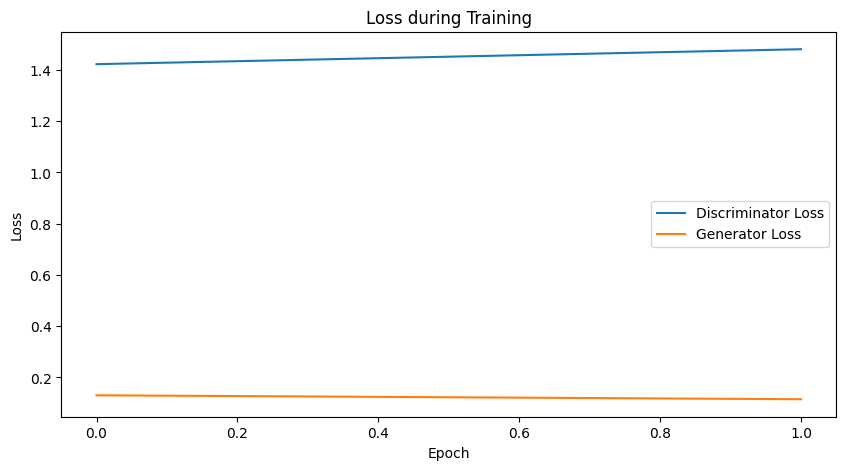

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


PermissionDeniedError: /mnt/data; Permission denied

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1) # Reshape to (28, 28, 1)

# Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Generator model
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', activation='tanh'))
    return model

# GAN model
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

# Instantiate models
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

# Compile models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training parameters
epochs = 2 #100
batch_size = 128
half_batch = int(batch_size / 2)
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, 100])

# Training loop
discriminator_loss, generator_loss = [], []
for epoch in range(epochs):
    for _ in range(X_train.shape[0] // batch_size):
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]

        # Generate a batch of fake images
        noise = tf.random.normal([half_batch, 100])
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = tf.random.normal([batch_size, 100])
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

    discriminator_loss.append(d_loss)
    generator_loss.append(g_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

# Generate images after training
generated_images = generator.predict(seed)
generated_images = 0.5 * generated_images + 0.5

# Plot generated images
fig, axs = plt.subplots(1, num_examples_to_generate, figsize=(15, 3))
for i in range(num_examples_to_generate):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.plot(generator_loss, label='Generator Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save generated images and models
generator.save('/mnt/data/generator_model.h5')
discriminator.save('/mnt/data/discriminator_model.h5')
gan.save('/mnt/data/gan_model.h5')



# Problem 2

In [ ]:
!pip install gymnasium

In [76]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
import time


##Problem 2a

In [26]:
def create_dqn_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(24, activation='relu', input_shape=input_shape),
        layers.Dense(48, activation='relu'),
        layers.Dense(output_shape, activation=None)
    ])
    return model

def create_dqn_model_large(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(output_shape, activation=None)
    ])
    return model

def create_dqn_model_small(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape),
        layers.Dense(output_shape, activation=None)
    ])
    return model


##Problem 2b

In [27]:
import numpy as np
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.

        Parameters
        ----------
        batch_size: int
            How many transitions to sample.

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


## Problem 2c

In [83]:
from re import VERBOSE
BUFFER_SIZE = 256
GAMMA = 0.99

env = gym.make('MountainCar-v0')
buffer = ReplayBuffer(BUFFER_SIZE)

def get_action(state, epsilon, model):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        Q_values = model.predict(state.reshape(1, -1))
        return np.argmax(Q_values[0])


def update_dqn_network(model, optimizer, buffer, batch_size):
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = buffer.sample(batch_size)
    Q_targets_next = model.predict(next_state_batch, verbose=0).max(axis=1)
    Q_targets = reward_batch + (GAMMA * Q_targets_next * (1 - done_batch))

    with tf.GradientTape() as tape:
        Q_expected = model(state_batch)
        Q_expected_relevant = tf.reduce_sum(Q_expected * tf.one_hot(action_batch, 3), axis=1)
        loss = tf.keras.losses.MSE(Q_expected_relevant, Q_targets)

    gradients = tape.gradient(loss, model.trainable_variables)
    #optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [84]:
NUM_EPISODES = 1000
EPISODE_SIZE = 500
BATCH_SIZE = 128
EPS_MAX = 1.0
EPS_DECAY = 0.995

model = create_dqn_model((2,), 3)  # or create_dqn_model_large, create_dqn_model_small
optimizer = tf.keras.optimizers.Adam()
rewards = []

for episode in range(NUM_EPISODES):
    start_time = time.time()  # Start time measurement
    episodic_reward = 0
    state = env.reset()
    state = np.array(state[0], dtype=np.float32)
    epsilon = EPS_MAX * (EPS_DECAY ** episode)

    for t in range(EPISODE_SIZE):
        action = get_action(state, epsilon, model)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.array(next_state, dtype=np.float32)
        buffer.add(state, action, reward, next_state, done)
        episodic_reward += reward
        state = next_state

        if len(buffer) > BATCH_SIZE:
            update_dqn_network(model, optimizer, buffer, BATCH_SIZE)

        if done:
            break
    episode_duration = time.time() - start_time
    rewards.append(episodic_reward)
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Reward: {episodic_reward}, Time: {episode_duration:.2f} seconds")


KeyboardInterrupt: ignored